# Minimal Model with linear fitness

(c) 2020 Tom Röschinger. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

***

In this notebook we go back a step and reduce the fitness model to a simple linear landscape. I'll use the foundation from the Jevo package and define a fitness landscape here which can be included in the package later.

In [4]:
using Plots, LinearAlgebra, Revise

# my packages
using Jevo, Jedi

Jedi.default_gr!()

Plots.GRBackend()

Here we use the fitness landscape $$F(\Gamma, l) = -f_l \, l + s(\Gamma_0 - \Gamma).$$

Let's do a small test of the parameters and plot the fitness landscape.

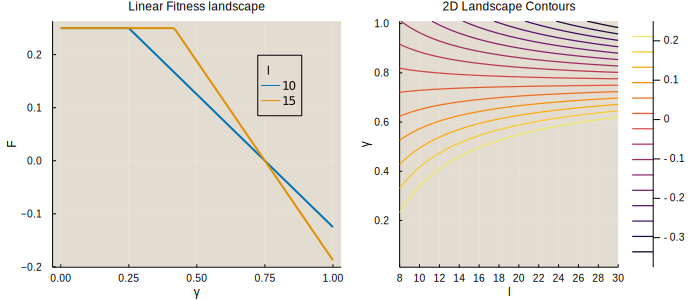

In [12]:
N = 100
f0 = 10/2N
l = 10
n = 4
ϵ = 1
fl = 0/2N

F = Jevo.semi_linear_fitness(f0=f0, fl=fl, l=l, n=n, epsilon=ϵ)

f_1 = Jevo.fitness.(collect(0:0.1:10), F)
p1 = plot(collect(0:0.1:10) ./ 10, f_1, xlabel="γ", ylabel="F", title="Linear Fitness landscape", linewidth=2, label=10, legendtitle="l")

f_1_1 = Jevo.fitness.(collect(0:0.1:15), 15, F)

plot!(p1, collect(0:0.1:15) ./ 15, f_1_1, linewidth=2, label=15)




f_2 = zeros(101, 23)
for (i, l) in enumerate(8:30)
    f_2[:, i] = Jevo.fitness.(collect(0:0.01:1) .* l .* ϵ, l, F)
end
p2 = contour(
    f_2, 
    yticks=([20, 40, 60, 80, 100], [20, 40, 60, 80, 100] ./ 100),
    xticks=(collect(1:2:23), collect(8:2:30)),
    xlabel="l",
    ylabel="γ",
    title="2D Landscape Contours"
)

plot(p1, p2, size=(700, 300))

In [13]:
function Q(k::Int, l::Int, F::Jevo.fitness_functions, n::Int, κ::Real, N::Int)
    # Neutral diversity
    q0 = binomial(BigInt(l), BigInt(k))  * ((n-1)/n)^k * (1/n)^(l-k)
    q = q0 * exp( (2N / (1+κ)) * Jevo.fitness(k * F.epsilon, l, F))
    return q
end

Q (generic function with 1 method)

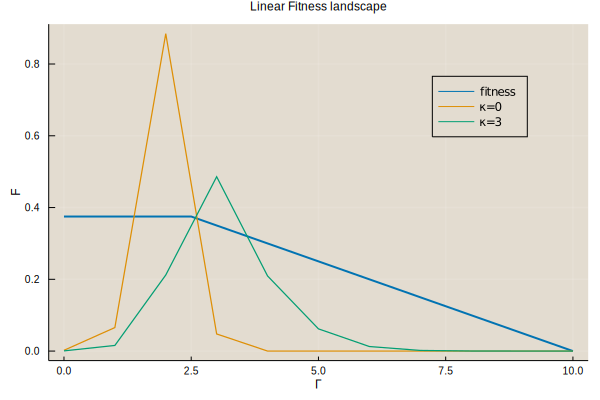

In [15]:
p3 = plot(0:0.1:10, f_1 .- minimum(f_1), xlabel="Γ", ylabel="F", title="Linear Fitness landscape", linewidth=2, label="fitness")

Q_0 = [Q(x, 10, F, n, 0, N) for x in collect(0:10) .* ϵ]
Q_0 = Q_0 / sum(Q_0)

Q_3 = [Q(x, 10, F, n, 3, N) for x in collect(0:10) .* ϵ]
Q_3 = Q_3 / sum(Q_3)

plot!(p3, [0:10, 0:10],[Q_0, Q_3], labels=["κ=0"  "κ=3"])

Let's confirm this by simply running a simulation without length mutations in this landscape.

In [16]:
# Simulation steps
steps = 1* 10^6
# Initial length
l_0 = 10
# Energy Matrix
emat = ϵ * (ones(4, 4) - Matrix{Float64}(I, 4, 4))

4×4 Array{Float64,2}:
 0.0  1.0  1.0  1.0
 1.0  0.0  1.0  1.0
 1.0  1.0  0.0  1.0
 1.0  1.0  1.0  0.0

In [17]:
t0 = zeros(2, 2, steps)

# Interate through driving rates
for (j, rho) in enumerate([0, 3])
    pop = Jevo.mono_pop(N=N, l=l_0)
    Jevo.initiate!(pop, emat)
    for i in 1:steps
        Jevo.bp_substitution!(pop, emat, F)
        if rand() < rho/N
            Jevo.driver_mutation!(pop)
        end
        if (rand() < 0/(10*N)) && length(pop.seqs) > 1
            Jevo.l_substitution!(pop, emat, F)
        end
        t0[j, :, i] = [Jevo.get_energy(pop, emat), length(pop.seqs)] 
    end
end

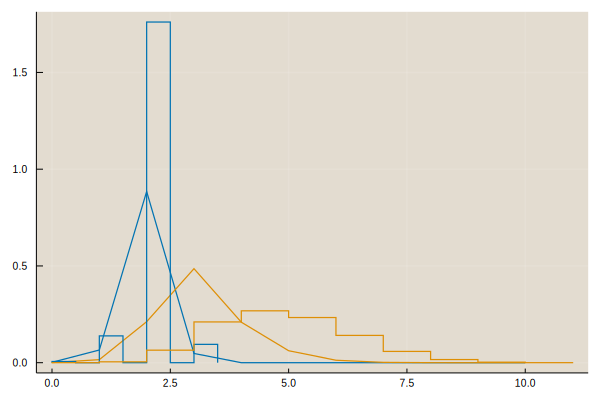

In [18]:
c1 = palette(:seaborn_colorblind)[1]
c2 = palette(:seaborn_colorblind)[2]

p_hists = plot(0:10, Q_0, color=c1)
plot!(p_hists, 0:10, Q_3, color=c2)

Jedi.histogram(p=p_hists, data=t0[1, 1, :], density=true, line_kwargs=Dict(:color=>c1))
Jedi.histogram(p=p_hists, data=t0[2, 1, :], density=true, line_kwargs=Dict(:color=>c2))

Next we introduce length mutations.

In [23]:
pop = Jevo.mono_pop(N=N, l=l_0)
Jevo.initiate!(pop, emat)
steps=10^7
F.fl=1.5/2N
t1 = zeros(2, 2, steps)

# Interate through driving rates
for (j, rho) in enumerate([0, 3])
    pop = Jevo.mono_pop(N=N, l=l_0)
    Jevo.initiate!(pop, emat)
    for i in 1:steps
        Jevo.bp_substitution!(pop, emat, F)
        if rand() < rho/N
            Jevo.driver_mutation!(pop)
        end
        if (rand() < 1/(10*N)) && length(pop.seqs) > 1
            Jevo.l_substitution!(pop, emat, F)
        end
        t1[j, :, i] = [Jevo.get_energy(pop, emat), length(pop.seqs)]
        if length(pop.seqs) < 6
            Jevo.initiate!(pop, emat)
        end
    end
end

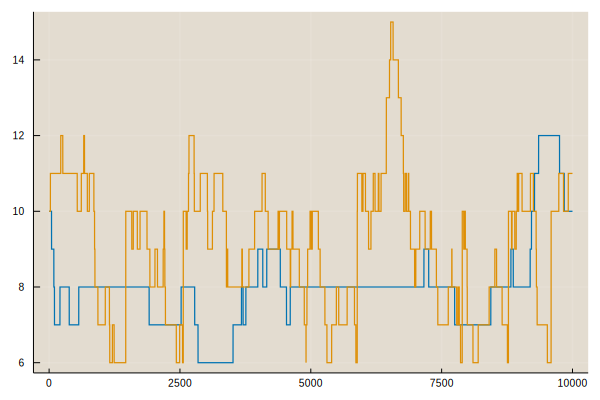

In [24]:
plot(t1[1, 2, 1:1000:end])
plot!(t1[2, 2, 1:1000:end])